In [1]:
import pandas as pd
import numpy as np
from math import sqrt, ceil
from timeit import timeit, Timer

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
import seaborn as sns
from matplotlib.animation import FuncAnimation
from matplotlib.patches import ConnectionPatch
import matplotlib.animation as animation

rc('text', usetex=False)
plt.style.use('seaborn')
%matplotlib inline

legend_opts = {
    'fontsize':12,
    'frameon':True, 
    'framealpha':1,
    'facecolor':'white',
    'edgecolor':'black',
    'labelspacing':0.1}

In [3]:
%load_ext autoreload
%aimport utils
%autoreload 1
from utils import *

In [4]:
%load_ext line_profiler
%load_ext memory_profiler

## Load data

In [5]:
male_scores = pd.read_csv('scores/trimmed_male.csv')
female_scores = pd.read_csv('scores/trimmed_female.csv')

In [6]:
# Randomly choose 10 years for training set, and remaining 4 years for test set
# (which must include the last year 2018 for visualisation purpose)
years_before_last = range(2005, 2018)
year_seed = np.random.RandomState(seed=42)
train_years = sorted(list(year_seed.choice(years_before_last, size=10, replace=False)))
test_years = sorted([year for year in years_before_last if year not in train_years] + [2018])
train_years, test_years

([2005, 2006, 2007, 2009, 2010, 2012, 2013, 2014, 2016, 2017],
 [2008, 2011, 2015, 2018])

In [7]:
all_season_scores = male_scores.loc[male_scores['event']!='WR']
all_world_scores = male_scores.loc[male_scores['event']=='WR']
all_years = range(2005, 2019)

# Combine latent scores using logistic regression

## Multi-factor model

In [100]:
def train_multi_log(season_scores, skater_order=None, init_seed=42,
             alpha=0.0005, n_iter=1000, n_factors=2, log_every=10, additional_iter=[], verbose=False):
    '''
    Run gradient descent on some season scores table (long format)
    Generate latent scores and other intermediate values at certain iterations'''
    
    # Convert long table to pivot table
    season_pivot = pd.pivot_table(season_scores[['name', 'event', 'score']], values='score', index='name', columns='event')
    
    # Modify skater position in pivot table (for aesthetic value only)
    if skater_order is not None:
        season_pivot = season_pivot.loc[skater_order]
        
    # Store skater and event names to retrieve later
    skater_names = list(season_pivot.index)
    event_names = list(season_pivot.columns)
    
    # Convert pivot table to numpy array
    true_scores = season_pivot.values

    # Step 1: Initialize baseline score, and scores of all factors
    random_state = np.random.RandomState(init_seed)
    baseline = random_state.random_sample()   
    event_scores = random_state.random_sample((n_factors, len(event_names)))
    skater_scores = random_state.random_sample((len(skater_names), n_factors))        

    
    # Step 2: repeat until convergence
    for i in range(n_iter):
        # a. Calculate residual for every event-skater pair
        predicted_scores = skater_scores @ event_scores + baseline
        residuals = predicted_scores - true_scores
            
        
        # Log intermediate values at certain iterations if logging is enabled
        if (i%log_every==0) or (i in additional_iter) or (i==n_iter-1):
            rmse = np.sqrt(np.nanmean(residuals**2))
            yield i, true_scores, event_names, skater_names, baseline, event_scores, skater_scores, residuals, rmse

        # b. Calculate baseline gradient and update baseline score
        baseline_gradient = np.nansum(residuals)
        baseline = baseline - alpha * baseline_gradient
    
        # Reshaped matrices
        reshaped_residuals = residuals[np.newaxis, :, :]
        reshaped_event_scores = event_scores[:, np.newaxis, :]
        reshaped_skater_scores = skater_scores.T[:, :, np.newaxis]
        
        
        # c-i: Calculate gradients for all factors
        residuals = residuals[np.newaxis, :, :]
        event_gradients = np.nansum(residuals * skater_scores.T[:, :, np.newaxis], axis=1)
        skater_gradients = np.nansum(residuals * event_scores[:, np.newaxis, :], axis=2)
        
        # 2c-ii: Update latent scores for all factors
        event_scores = event_scores - alpha * event_gradients
        skater_scores = skater_scores - alpha * skater_gradients.T
    
        if verbose and i==(n_iter-1):
            rmse_old = np.sqrt(np.nanmean(residuals**2))
            residuals = skater_scores @ event_scores + baseline - true_scores
            rmse_new = np.sqrt(np.nanmean(residuals**2))
            print(f'Alpha: {alpha}, Iter: {i}, Last RMSE: {round(rmse_new, 2)}, Delta RMSE: {round(rmse_new - rmse_old, 10)}')

In [101]:
def train_multi(season_scores, **kwargs):
    '''
    Run gradient descent on some season scores table (long format)
    Return latent scores at the end of algorithms
    '''
    log_values = None
    for log_values in train_multi_log(season_scores, **kwargs):
        pass
    
    event_names = log_values[2]
    skater_names = log_values[3]
    baseline = log_values[4]
    event_scores = log_values[5]
    skater_scores = log_values[6]
    
    event_scores = pd.DataFrame(event_scores.T, index=event_names)
    skater_scores = pd.DataFrame(skater_scores, index=skater_names) 
    
    return baseline, event_scores, skater_scores    

## Logistic regression on toy example

In [10]:
season_scores, world_scores = get_yearly_scores(2017, all_season_scores, all_world_scores)

# Select relevant rows from male season scores in 2017 for toy example
sample_season_scores = season_scores.loc[[1758, 1760, 1765, 1769, 1771, 1776, 1787]]

# Transform long score table to pivot form
season_pivot = pd.pivot_table(sample_season_scores[['name', 'event', 'score']], values='score', index='name', columns='event')
# Store skater and event names to retrieve later
skater_names = list(season_pivot.index) # ['Alexander, MAJOROV', 'Javier, FERNANDEZ', 'Misha, GE', 'Takahito, MURA']
event_names = list(season_pivot.columns) # ['CA', 'FR', 'RU']

# Convert pivot table to numpy array
true_scores = season_pivot.values 
true_scores

array([[   nan,    nan, 192.14],
       [   nan, 285.38, 292.98],
       [226.07, 229.06,    nan],
       [222.13, 248.42,    nan]])

In [11]:
# Get latent scores from multi-factor model
baseline, event_scores, skater_scores = train_multi(sample_season_scores, init_seed=42,
alpha=0.0005, n_iter=1000, n_factors=2)

Alpha: 0.0005, Iter: 999, Last RMSE: 0.0, Delta RMSE: -4.13612e-05


In [12]:
# Sort skater scores by world championship ranking
world_ranking = ['Javier, FERNANDEZ', 'Takahito, MURA', 'Misha, GE', 'Alexander, MAJOROV']
skater_scores = skater_scores.reindex(world_ranking)
skater_scores = skater_scores.values
skater_scores

array([[16.00924695,  4.59479654],
       [14.05960699,  3.02043372],
       [11.91968722,  7.28073589],
       [10.22685723,  3.12272322]])

In [13]:
# Normalize skater scores
normed_skater_scores = (skater_scores - skater_scores.mean(axis=0)) / skater_scores.std(axis=0)
normed_skater_scores

array([[ 1.35516899,  0.05241153],
       [ 0.46118036, -0.86315562],
       [-0.52005923,  1.61441349],
       [-1.29629012, -0.80366939]])

In [14]:
# Generate pairwise differences 
X = np.array([row1 - row2 for row1, row2 in combinations(normed_skater_scores, 2)])
X

array([[ 0.89398863,  0.91556715],
       [ 1.87522822, -1.56200196],
       [ 2.65145911,  0.85608092],
       [ 0.98123959, -2.47756911],
       [ 1.75747048, -0.05948623],
       [ 0.77623089,  2.41808288]])

In [15]:
# Train logistic regression model
beta = np.full(2, 0.5)
alpha = 0.001
n_iter = 100

# Repeat unitl convergence
for i in range(n_iter):
    # a. Calculate predicted probabilities
    prob = 1 / (1 + np.exp(-X @ beta))
    # b. Calculate gradients
    gradient = (1 - prob) @ X
    # c. Update factor coefficients
    beta = beta + alpha * gradient
    
    if i in [n_iter-2, n_iter-1]:
        print(f'i: {i}, avg ll: {np.log(prob).sum()/len(X)}')

i: 98, avg ll: -0.33699690340025407
i: 99, avg ll: -0.3360536002800105


In [16]:
# Output model coefficients
beta

array([0.74509524, 0.36718924])

In [17]:
# Predict probability and binary reponse for each observation
prob = 1 / (1 + np.exp(-X @ beta))
y_pred = prob > 0.5
y_pred

array([ True,  True,  True, False,  True,  True])

In [18]:
# Calculate combined scores from model coefficient and sort them from highest to lowest
combined_scores = normed_skater_scores @ beta
sorted_combined_scores = pd.Series(combined_scores, index=world_ranking).sort_values(ascending=False)
sorted_combined_scores

Javier, FERNANDEZ     1.028975
Misha, GE             0.205302
Takahito, MURA        0.026682
Alexander, MAJOROV   -1.260958
dtype: float64

In [19]:
# Predicted ranking from combined score
predicted_ranking = list(sorted_combined_scores.index)
predicted_ranking

['Javier, FERNANDEZ', 'Misha, GE', 'Takahito, MURA', 'Alexander, MAJOROV']

In [20]:
def convert_to_ranking(y_pred, world_ranking):
    '''
    Convert binary response to pairwise ranking, along with a reference world ranking
    Return predicted ranking with the same length as the world ranking
    '''
    n_skaters = len(world_ranking)
    counter = [0] * n_skaters
    index_pairs = combinations(range(n_skaters), 2)
    for y, (i, j) in zip(y_pred, index_pairs):
        if y == True:
            counter[i] += 1
        else:
            counter[j] += 1
            
    predicted_ranking = [skater for rank, skater in sorted(zip(counter, world_ranking), reverse=True)]
    
    return predicted_ranking

In [21]:
convert_to_ranking(y_pred, world_ranking)

['Javier, FERNANDEZ', 'Misha, GE', 'Takahito, MURA', 'Alexander, MAJOROV']

## Apply logistic regression to 2017 male skaters

In [22]:
def log_gradient_ascent_log(X, alpha=0.001, n_iter=1000, seed=42, log_every=10, additional_iter=[], verbose=True):
    '''
    Train logistic regression model on predictor matrix
    Yield model coefficients and other information at specified iteration
    '''
    beta = np.full(X.shape[1], 0.5)
    ll_log = []
    
    if n_iter == 0:
        yield 0, beta, None
    
    for i in range(n_iter):
        prob = 1 / (1 + np.exp(-X @ beta))
        ll_avg = np.log(prob).sum() / len(X) 
       
        # Log values before update
        if (i%log_every==0) or (i in additional_iter) or (i==n_iter-1):
            yield i, beta, ll_avg
        
        gradient = (1 - prob) @ X
        beta = beta + alpha * gradient
        
        if verbose and i in [n_iter-1]:
            prob_new = 1 / (1 + np.exp(-X @ beta))
            ll_avg_new = np.log(prob_new).sum() / len(X)
            print(f'Alpha: {alpha}, Iter: {i}, Last LL: {round(ll_avg_new, 2)}, Delta LL: {round(ll_avg_new - ll_avg, 10)}')

In [54]:
def log_gradient_ascent(X, **kwargs):
    '''
    Train logistic regression model on predictor matrix
    Return model coefficient at the end
    '''
    log_values = None
    for log_values in log_gradient_ascent_log(X, **kwargs):
        pass
    
    last_beta = log_values[1]
    return last_beta    

In [109]:
# Run multi-factor model on 2017 male skaters (with 5 factors)
season_scores, world_scores = get_yearly_scores(2017, all_season_scores, all_world_scores)
baseline, event_scores, skater_scores = train_multi(season_scores,
alpha=0.0005, n_iter=1000, n_factors=5)

In [110]:
# Generate predictor model
skater_scores = skater_scores.reindex(world_scores.index).dropna()
skater_scores = skater_scores.values
normed_skater_scores = (skater_scores - skater_scores.mean(axis=0)) / skater_scores.std(axis=0)
X = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(normed_skater_scores, 2)))
print(X.shape)
X

(276, 5)


array([[-1.12999067, -0.3468028 ,  1.06511662,  1.05860272,  1.08244262],
       [-1.19042684, -2.18007772,  3.42139988,  1.73351244,  2.62881917],
       [ 1.05592683, -1.06296375,  1.12682267, -0.2796619 ,  1.20797399],
       ...,
       [ 0.8037746 , -0.43257676, -0.49792667,  0.60811669, -0.99280602],
       [ 0.02509795, -0.37119253, -0.06268704, -0.13973247, -0.51634769],
       [-0.77867665,  0.06138423,  0.43523962, -0.74784916,  0.47645832]])

In [111]:
# Run logistic regression model on predictor matrix
beta = log_gradient_ascent(X, alpha=0.001, n_iter=300)
beta

Alpha: 0.001, Iter: 299, Last LL: -0.26, Delta LL: 5.5607e-06


array([ 2.07857253,  0.83709383, -0.0679788 ,  0.9119482 ,  1.80625539])

In [112]:
# Predict binary reponse to pairwise ranking and evaluate how many pairs are correct
y_pred = (X @ beta) > 0
y_pred.sum()

244

In [113]:
# Generate reference world ranking
avg_scores = season_scores.groupby('name')['score'].mean()
_, world_ranking = return_ranking(avg_scores, world_scores)

In [114]:
# Get predicted ranking from binary predictions and compare to reference world ranking
predicted_ranking = convert_to_ranking(y_pred, world_ranking)
calculate_kendall_tau(predicted_ranking, world_ranking)

There are 244 concordant_pairs out of 276 pairs


0.7681159420289855

In [115]:
# Get all normalized skater latent scores along with combined scores
result_scores = pd.DataFrame(normed_skater_scores, index=world_ranking)
result_scores['Combined'] = normed_skater_scores @ beta
result_scores.head()

,0,1,2,3,4,Combined
"Yuzuru, HANYU",0.686300,-0.584228,1.518619,1.505833,1.884022,5.610505
"Shoma, UNO",1.816291,-0.237425,0.453502,0.447231,0.801580,5.401425
"Boyang, JIN",1.876727,1.595849,-1.902781,-0.227679,-0.744797,3.813213
"Javier, FERNANDEZ",-0.369627,0.478735,0.391796,1.785495,0.676048,2.455212
"Patrick, CHAN",0.654184,0.764091,0.328854,-0.089437,1.170852,4.010325


In [116]:
# Rank skaters by each individual score
result_ranks = result_scores.values.argsort(axis=0).argsort(axis=0)
pd.DataFrame(result_ranks, index=world_ranking).head()

,0,1,2,3,4,5
"Yuzuru, HANYU",18,3,22,20,22,23
"Shoma, UNO",21,9,17,15,18,22
"Boyang, JIN",22,22,0,11,6,20
"Javier, FERNANDEZ",9,16,16,23,16,18
"Patrick, CHAN",17,18,14,12,20,21


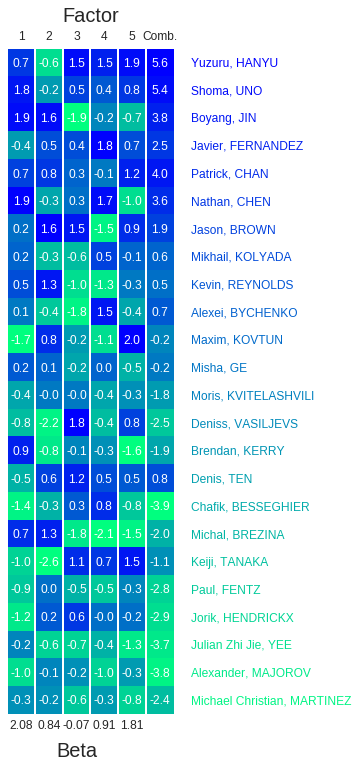

<Figure size 432x288 with 0 Axes>

In [120]:
# Plot scores and rankings from each latent factor, along with combined scores
winter_cmap = mpl.cm.get_cmap('winter')

fig = plt.figure(figsize=(6, 11))
grid = plt.GridSpec(1, 2, wspace=0, bottom=0.08, top=0.92)
ax = fig.add_subplot(grid[:, 0])
ax1 = fig.add_subplot(grid[:, 1], sharey=ax)

n_skaters = result_scores.shape[0]
n_scores = result_scores.shape[1]

ax.imshow(result_ranks, cmap='winter_r')
ax.grid(None)

for i in range(n_skaters):
    ax1.text(0.1, i, f'{world_ranking[i]}', ha='left', va='center', color=winter_cmap(i/n_skaters), fontsize=12)
    for j in range(n_scores):
        ax.text(j, i, f'{result_scores.iloc[i, j]:.1f}', ha='center', va='center', color='w', fontsize=12)
        
for i in range(n_scores):
    ax.axvline(i-0.5, lw=2, color='w')
    
ax.set_yticks([])
ax.set_xticks(range(result_scores.shape[1]))
ax.set_xticklabels(['1', '2', '3', '4', '5', 'Comb.'], fontsize=12)

ax.xaxis.tick_top()
ax.yaxis.tick_right()

for i, b in enumerate(beta):
    ax.text(i, n_skaters, f'{b:.2f}', ha='center', fontsize=12)
ax.text(n_scores/2-1, n_skaters+1, 'Beta', ha='center', fontsize=20)   
ax.text(n_scores/2-0.5, -1.5, 'Factor', ha='center', fontsize=20)  

ax1.set_facecolor('w')
ax1.set_xticks([])

plt.show()
plt.tight_layout()
fig.savefig('viz/5_factors_simul.png')

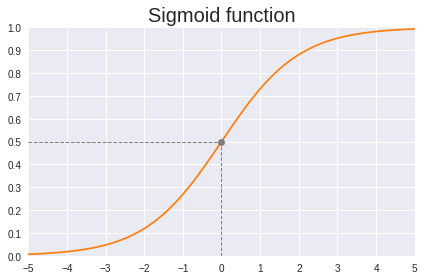

In [118]:
# Plot sigmoid function for write-up
z = np.arange(-5, 5, 0.01)
fz = 1 / (1+np.exp(-z))
plt.plot(z, fz, color='tab:orange')
plt.xlim(-5, 5)
plt.xticks(range(-5, 6))
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.01, 0.1))
plt.plot(0, 0.5, 'o', color='tab:gray')

plt.hlines(0.5, -5, 0, linestyles='--', lw=1, colors='tab:gray')
plt.vlines(0, 0, 0.5, linestyles='--', lw=1, colors='tab:gray')
plt.title('Sigmoid function', fontsize=20)

plt.tight_layout()
plt.savefig('viz/sigmoid.png', figsize=(5,5))

### Animation (5 factors)

In [34]:
# Train logistic regression and prepare lists of value for animation to access one at a time
predicted_rankings = []
taus = []
lls = []
iter_log = []
betas = []

for i, beta, ll in log_gradient_ascent_log(X, alpha=0.0005, n_iter=251):
    y_pred = (X @ beta) > 0
    predicted_ranking = convert_to_ranking(y_pred, world_ranking)
    tau = calculate_kendall_tau(predicted_ranking, world_ranking, verbose=False)
    iter_log.append(i)
    betas.append(beta)
    lls.append(ll)
    predicted_rankings.append(predicted_ranking)
    taus.append(tau)

Alpha: 0.0005, Iter: 250, Last LL: -0.26, Delta LL: 4.32116e-05


In [35]:
# Get last tau and log-likelihood at the end (to compare with 50 factors later)
last_tau_5 = taus[-1]
last_ll_5 = lls[-1]

In [36]:
def update(i, fig, ax1, ax2, ax3, verbose=False):
    if verbose:
        print(i, end=' ')
    fig.suptitle(f'Iteration {iter_log[i]}\nα = 0.0005', x=0.5, y=0.85, va='bottom', ha='center', fontsize=20)
    
    if i == 0:
        ax1.plot(iter_log[i], lls[i], '.', color='tab:brown', clip_on=False)
        ax2.plot(iter_log[i], taus[i], '.', color='tab:orange', clip_on=False)
    if i >= 1:
        ax1.plot(iter_log[i-1:i+1], lls[i-1:i+1], '.-', color='tab:brown', clip_on=False)
        ax2.plot(iter_log[i-1:i+1], taus[i-1:i+1], '.-', color='tab:orange', clip_on=False)
        
    ax3.lines = []
    ax3.texts = []
    plot_multiple_rankings(fig, ax3, [predicted_rankings[i], world_ranking], ['Predicted', 'World'], xfontsize=15)

0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 0 

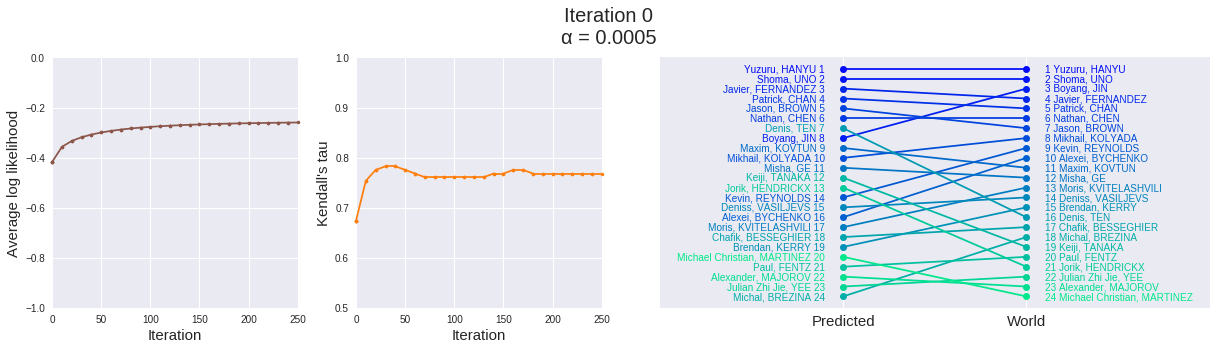

In [37]:
# Plot animation
fig = plt.figure(figsize=(17, 5))
grid = plt.GridSpec(6, 4)

ax1 = fig.add_subplot(grid[1:, 0])
ax1.set_xlim(0, iter_log[-1])
ax1.set_ylim(-1, 0)
ax1.set_yticks(np.arange(-1, 0.01, 0.2))
ax1.set_xlabel('Iteration', fontsize=15)
ax1.set_ylabel('Average log likelihood', fontsize=15)

ax2 = fig.add_subplot(grid[1:, 1])
ax2.set_xlim(0, iter_log[-1])
ax2.set_ylim(0.5, 1)
ax2.set_xlabel('Iteration', fontsize=15)
ax2.set_ylabel("Kendall's tau", fontsize=15)

ax3 = fig.add_subplot(grid[1:, 2:])

anim = FuncAnimation(fig, lambda i: update(i, fig, ax1, ax2, ax3, verbose=True), 
                     frames=len(iter_log), interval=500)

anim.save('viz/log_anim_5.gif', writer='imagemagick')

### Animation (50 factors)

In [38]:
# Train multi-factor model
season_scores, world_scores = get_yearly_scores(2017, all_season_scores, all_world_scores)
baseline, event_scores, skater_scores = train_multi(season_scores,
alpha=0.0005, n_iter=1000, n_factors=50)

Alpha: 0.0005, Iter: 999, Last RMSE: 0.0, Delta RMSE: -8.7e-09


In [39]:
# Get predictor matrix for logistic regression
skater_scores = skater_scores.reindex(world_scores.index).dropna()
skater_scores = skater_scores.values
normed_skater_scores = (skater_scores - skater_scores.mean(axis=0)) / skater_scores.std(axis=0)
X = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(normed_skater_scores, 2)))
X

# Train logistic regression and prepare lists of value for animation to access one at a time
predicted_rankings = []
taus = []
lls = []
iter_log = []
betas = []

for i, beta, ll in log_gradient_ascent_log(X, alpha=0.001, n_iter=251):
    y_pred = (X @ beta) > 0
    predicted_ranking = convert_to_ranking(y_pred, world_ranking)
    tau = calculate_kendall_tau(predicted_ranking, world_ranking, verbose=False)
    iter_log.append(i)
    betas.append(beta)
    lls.append(ll)
    predicted_rankings.append(predicted_ranking)
    taus.append(tau)

Alpha: 0.001, Iter: 250, Last LL: -0.05, Delta LL: 8.89282e-05


0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 0 

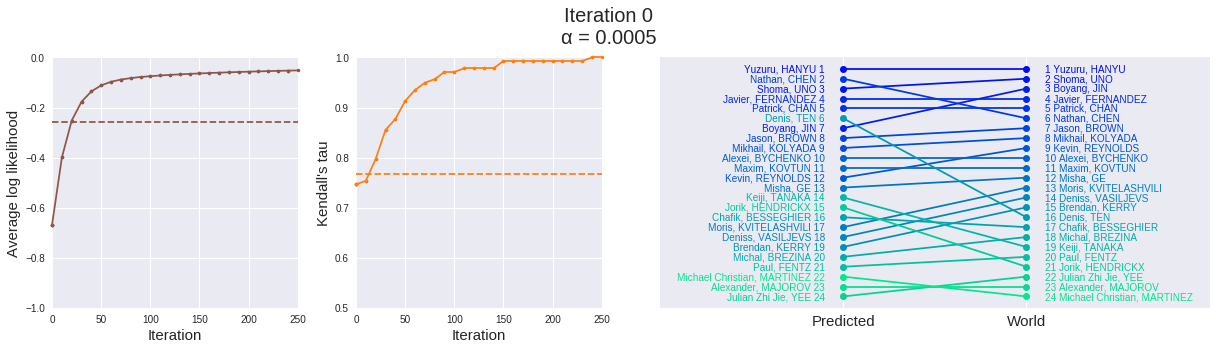

In [40]:
# Plot animation
fig = plt.figure(figsize=(17, 5))
grid = plt.GridSpec(6, 4)

ax1 = fig.add_subplot(grid[1:, 0])
ax1.set_xlim(0, iter_log[-1])
ax1.set_ylim(-1, 0)
ax1.set_yticks(np.arange(-1, 0.01, 0.2))
ax1.set_xlabel('Iteration', fontsize=15)
ax1.set_ylabel('Average log likelihood', fontsize=15)
ax1.axhline(last_ll_5, color='tab:brown', ls='--')

ax2 = fig.add_subplot(grid[1:, 1])
ax2.set_xlim(0, iter_log[-1])
ax2.set_ylim(0.5, 1)
ax2.set_xlabel('Iteration', fontsize=15)
ax2.set_ylabel("Kendall's tau", fontsize=15)
ax2.axhline(last_tau_5, color='tab:orange', ls='--')

ax3 = fig.add_subplot(grid[1:, 2:])

anim = FuncAnimation(fig, lambda i: update(i, fig, ax1, ax2, ax3, verbose=True), 
                     frames=len(iter_log), interval=500)

anim.save('viz/log_anim_50.gif', writer='imagemagick')

# Change number of factors

In [41]:
# Split 10 years into train and validation set
random_state = np.random.RandomState(seed=42)
years1 = list(random_state.choice(train_years, size=5, replace=False))
years2 = [year for year in train_years if year not in years1]
years1, years2

([2016, 2006, 2012, 2005, 2014], [2007, 2009, 2010, 2013, 2017])

In [42]:
def get_tau_from_X_beta(X, beta):
    '''
    Get Kendall's tau from predictor matrix and model coefficient
    by counting concordant pairs in predicted binary response
    '''
    n_concordant_pairs = (X @ beta > 0).sum()
    n_pairs = len(X)
    return (2 * n_concordant_pairs - n_pairs) / n_pairs

In [43]:
# Get yearly Kendall's tau from average model for comparison
avg = AverageScore()
avg_result = avg.evaluate_over_years(all_years, all_season_scores, all_world_scores).set_index('year')
avg_taus = avg_result['tau'].to_dict()

In [44]:
def cross_val_by_factor(n_factor, years1, years2, season_scores_df, world_scores_df, avg_taus,
                       alpha_multi=0.0005, alpha_log=0.0005, n_iter_multi=1001, n_iter_log=1001):
    '''
    From a given number of factors, train multi-model and logistic regression models
    and return all improvements in Kendall's tau for the train set and the validation set 
    '''
    X1 = {}
    X2 = {}

    for year in (years1 + years2):
        print(year, end=' ')
        
        # Step 1: train multi-factor model
        season_scores, world_scores = get_yearly_scores(year, season_scores_df, world_scores_df)
        baseline, event_scores, skater_scores = train_multi(season_scores, alpha=alpha_multi, n_iter=n_iter_multi,
                                                            n_factors=n_factor)
        
        # Normalize and take pairwise differences
        skater_scores = skater_scores.reindex(world_scores.index).dropna()
        normed_skater_scores = (skater_scores - skater_scores.mean(axis=0)) / skater_scores.std(axis=0)
        X = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(normed_skater_scores.values, 2)))
        
        # Store difference matrices for each year (separately for 1st and 2nd fold)
        if year in years1:
            X1[year] = X
        else:
            X2[year] = X
    
    # Stack predictor matrices for both folds
    stacked_X1 = np.concatenate(list(X1.values()))
    stacked_X2 = np.concatenate(list(X2.values()))
    
    # Step 2: train logistic regression model for both folds
    print('1st fold')
    beta1 = log_gradient_ascent(stacked_X1, alpha=alpha_log, n_iter=n_iter_log)
    print('2nd fold')
    beta2 = log_gradient_ascent(stacked_X2, alpha=alpha_log, n_iter=n_iter_log)
    
    # Step 3 & 4: evaluate logistic regression model on both folds
    dtaus_train = {}
    dtaus_val = {}
    for year in years1:
        dtaus_train[year] = get_tau_from_X_beta(X1[year], beta1) - avg_taus[year]
        dtaus_val[year] = get_tau_from_X_beta(X1[year], beta2) - avg_taus[year]
    for year in years2:
        dtaus_train[year] = get_tau_from_X_beta(X2[year], beta2) - avg_taus[year]
        dtaus_val[year] = get_tau_from_X_beta(X2[year], beta1) - avg_taus[year]
        
    return dtaus_train, dtaus_val

In [45]:
# Perform 2-fold cross validation for each factors (2,4,8,...,128)
n_factors = 2**np.arange(1, 8)
dtaus_train_all = {}
dtaus_val_all = {}

for n_factor in n_factors:
    print(f'{n_factor} factors')
    dtaus_train, dtaus_val = cross_val_by_factor(n_factor, years1, years2, all_season_scores, all_world_scores, avg_taus)
    dtaus_train_all[n_factor] = dtaus_train
    dtaus_val_all[n_factor] = dtaus_val

2 factors
2016 Alpha: 0.0005, Iter: 1000, Last RMSE: 2.41, Delta RMSE: -0.0003150945
2006 Alpha: 0.0005, Iter: 1000, Last RMSE: 3.45, Delta RMSE: -0.0003684736
2012 Alpha: 0.0005, Iter: 1000, Last RMSE: 2.29, Delta RMSE: -0.0007386162
2005 Alpha: 0.0005, Iter: 1000, Last RMSE: 3.25, Delta RMSE: -0.0009898611
2014 Alpha: 0.0005, Iter: 1000, Last RMSE: 4.22, Delta RMSE: -0.0003906191
2007 Alpha: 0.0005, Iter: 1000, Last RMSE: 1.56, Delta RMSE: -0.0002505081
2009 Alpha: 0.0005, Iter: 1000, Last RMSE: 2.75, Delta RMSE: -0.0001170689
2010 Alpha: 0.0005, Iter: 1000, Last RMSE: 4.57, Delta RMSE: -0.0001430355
2013 Alpha: 0.0005, Iter: 1000, Last RMSE: 4.71, Delta RMSE: -0.0002889748
2017 Alpha: 0.0005, Iter: 1000, Last RMSE: 4.44, Delta RMSE: -0.0001758436
1st fold
Alpha: 0.0005, Iter: 1000, Last LL: -0.45, Delta LL: 0.0
2nd fold
Alpha: 0.0005, Iter: 1000, Last LL: -0.45, Delta LL: 0.0
4 factors
2016 Alpha: 0.0005, Iter: 1000, Last RMSE: 0.01, Delta RMSE: -2.86559e-05
2006 Alpha: 0.0005, Iter

In [46]:
# Collect all Kendall's improvements into a matrix (one for train, one for validation)
dtaus_train_all = pd.DataFrame(dtaus_train_all)
dtaus_val_all = pd.DataFrame(dtaus_val_all)
dtaus_train_all.head()

,2,4,8,16,32,64,128
2005,-0.152381,-0.038095,-0.009524,0.066667,0.095238,0.133333,0.266667
2006,-0.181818,-0.023715,-0.031621,-0.071146,-0.015810,0.142292,0.276680
2007,-0.072464,0.014493,-0.007246,-0.007246,0.072464,0.210145,0.268116
2009,-0.007246,-0.007246,0.036232,0.050725,0.108696,0.217391,0.311594
2010,-0.216450,0.008658,0.017316,0.025974,0.086580,0.138528,0.173160


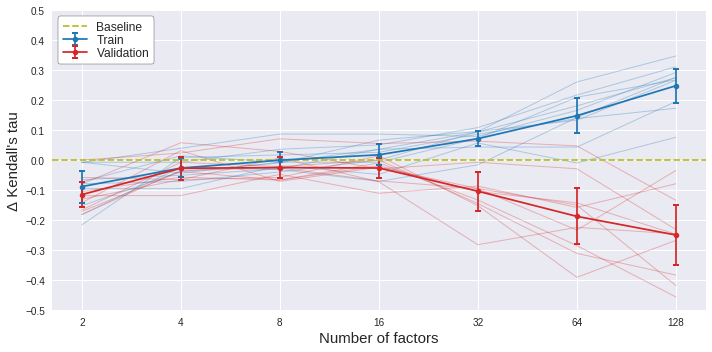

In [47]:
# Plot Kendall's tau difference for each year in train and validation,
# as well as a confidence interval line for average Kendall's tau improvement
fig, ax = plt.subplots(figsize=(10, 5))
ci_multiplier = 2.262/np.sqrt(10)

errorbar_opts = {'markeredgewidth': 2, 'capsize': 3}

for _, row in dtaus_train_all.iterrows():
    ax.plot(range(len(n_factors)), row, lw=1, color='tab:blue', alpha=0.3, label='_nolegend_')
ax.errorbar(range(len(n_factors)), dtaus_train_all.mean(axis=0), 
             yerr=ci_multiplier*dtaus_train_all.std(axis=0),
           fmt='.-', color='tab:blue', label='Train', **errorbar_opts)

for _, row in dtaus_val_all.iterrows():
    ax.plot(range(len(n_factors)), row, lw=1, color='tab:red', alpha=0.3, label='_nolegend_')
ax.errorbar(range(len(n_factors)), dtaus_val_all.mean(axis=0), 
             yerr=ci_multiplier*dtaus_val_all.std(axis=0),
           fmt='.-', color='tab:red', label='Validation', **errorbar_opts)

ax.axhline(0, ls='--', color='tab:olive', label='Baseline')
ax.legend(**legend_opts)

ax.set_xticks(range(len(n_factors)))
ax.set_xticklabels(n_factors)
ax.set_yticks(np.arange(-0.5, 0.51, 0.1))
ax.set_xlabel('Number of factors', fontsize=15)
ax.set_ylabel("Δ Kendall's tau", fontsize=15)

plt.tight_layout()
fig.savefig('viz/factors_vs_dtau_simul_svd.png')

# Early stopping

In [65]:
def cross_val_by_factor_log(n_factor, years1, years2, season_scores_df, world_scores_df, avg_taus,
                            n_multi_iter, n_log_iter,
                            multi_alpha=0.0005, log_alpha=0.0005,
                            log_multi_every=10, log_log_every=10):
    '''
    From a given number of factors, train multi-model and logistic regression models
    and return the average Kendall's tau for the train set and the validation set
    at specified iterations of multi-factor and logistic regresion model
    '''
    multi_gens = {}
    world_scores_by_year = {}
    
    # Store generators for multi-factor model for each year, as well as world scores for that year
    for year in (years1 + years2):
        season_scores, world_scores = get_yearly_scores(year, season_scores_df, world_scores_df)
        multi_gens[year] = train_multi_log(season_scores, n_factors=n_factor, alpha=multi_alpha,
                                           n_iter=n_multi_iter, log_every=log_multi_every, verbose=False)
        world_scores_by_year[year] = world_scores

    avg_dtaus_train = {}
    avg_dtaus_val = {}
    
    # Continue retrieving logs at specified iterations of multi-factor model\
    # until the generator for each year is exhausted
    while True:
        try:
            X1 = {}
            X2 = {}
            for year, multi_gen in multi_gens.items():
                try:
                    # Run multi-factor model by retrieving the next output of the model generator
                    multi_log = next(multi_gen)
                    multi_iter = multi_log[0]
                    skater_names = multi_log[3]
                    skater_scores = pd.DataFrame(multi_log[6], index=skater_names)
                    skater_scores = skater_scores.reindex(world_scores_by_year[year].index).dropna()
                    normed_skater_scores = (skater_scores - skater_scores.mean(axis=0)) / skater_scores.std(axis=0)
                    X = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(normed_skater_scores.values, 2)))
                    
                    # Collect predictor matrix for each year in separate matrices (1st and 2nd fold)
                    if year in years1:
                        X1[year] = X
                    else:
                        X2[year] = X
                # Once the first yearly generator of multi-factor is exhausted (which means all of them are)
                # stop training logistic regression model afterward
                except StopIteration as s:
                    raise s

            # If the generators of multi-factor model value still return values,
            # use the values 
            stacked_X1 = np.concatenate(list(X1.values()))
            stacked_X2 = np.concatenate(list(X2.values()))
            
            # Create logistic regression model generators for each fold
            log_gen1 = log_gradient_ascent_log(stacked_X1, alpha=log_alpha, n_iter=n_log_iter, log_every=log_log_every, verbose=False)
            log_gen2 = log_gradient_ascent_log(stacked_X2, alpha=log_alpha, n_iter=n_log_iter, log_every=log_log_every, verbose=False)
            
            # Train logistic regression model on each fold and return logged values at specified iterations
            for log_log1, log_log2 in zip(log_gen1, log_gen2):
                log_iter = log_log1[0]
                beta1 = log_log1[1]
                beta2 = log_log2[1]
                
                # Model coefficients at specified iterations are used to evaluate
                # improvement in Kendall's tau on both folds
                dtaus_train = {}
                dtaus_val = {}
                for year in years1:
                    dtaus_train[year] = get_tau_from_X_beta(X1[year], beta1) - avg_taus[year]
                    dtaus_val[year] = get_tau_from_X_beta(X1[year], beta2) - avg_taus[year]
                for year in years2:
                    dtaus_train[year] = get_tau_from_X_beta(X2[year], beta2) - avg_taus[year]
                    dtaus_val[year] = get_tau_from_X_beta(X2[year], beta1) - avg_taus[year]
                
                # Take average improvement in Kendall's tau for each combination of
                # stopping iterations of multi-factor and logistic regression model
                avg_dtaus_train[(multi_iter, log_iter)] = np.mean(list(dtaus_train.values()))
                avg_dtaus_val[(multi_iter, log_iter)] = np.mean(list(dtaus_val.values()))
        
        # If the multi-factor model generators are exhausted, end the outer loop too
        except StopIteration:
            break
    
    return pd.Series(avg_dtaus_train).unstack(), pd.Series(avg_dtaus_val).unstack()

In [66]:
# Perform 2-fold cross validation for each factors (2,4,8,...,128)
n_factors = 2**np.arange(1, 8)
avg_dtaus_train_all = {}
avg_dtaus_val_all = {}

for n_factor in n_factors:
    print(f'{n_factor} factors')
    avg_dtaus_train, avg_dtaus_val = cross_val_by_factor_log(n_factor, years1, years2, all_season_scores, all_world_scores, avg_taus,
                                    n_multi_iter=1001, n_log_iter=1001,
                                    log_multi_every=20, log_log_every=20)
    avg_dtaus_train_all[n_factor] = avg_dtaus_train
    avg_dtaus_val_all[n_factor] = avg_dtaus_val

2 factors
4 factors
8 factors
16 factors
32 factors
64 factors
128 factors


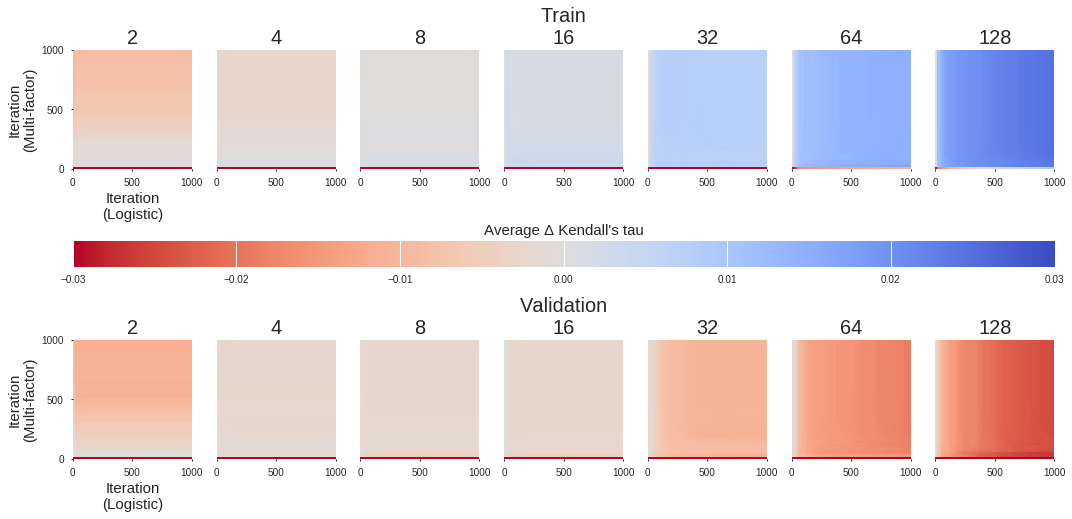

In [121]:
# Plot effects of number of factors, stopping iterations of multi-factor and logistic regression model
# for average Kendall's tau improvement for both train and validation set
fig = plt.figure(figsize=(15, 8))
grid = plt.GridSpec(21, len(n_factors), hspace=0)

for i, (n_factor, taus) in enumerate(avg_dtaus_train_all.items()):
    ax = fig.add_subplot(grid[:10, i])
    ax.set_xticks(range(0, 1001, 500))
    ax.set_yticks(range(0, 1001, 500))
    ax.imshow(taus.iloc[::-1, :], cmap='coolwarm_r', vmin=-0.3, vmax=0.3, extent=[0, 1000, 0, 1000])
    ax.grid(None)
    ax.set_title(f'{n_factor}', fontsize=20)
    ax.tick_params(direction='out', length=2)
    if i == 0:
        ax.set_xlabel('Iteration\n(Logistic)', fontsize=15)
        ax.set_ylabel('Iteration\n(Multi-factor)', fontsize=15)        
    else:
        ax.set_yticks([])
        if i == 3:
            ax.set_title(f'Train\n{n_factor}', fontsize=20)
        else:
            ax.set_title(f'{n_factor}', fontsize=20)
        

for i, (n_factor, taus) in enumerate(avg_dtaus_val_all.items()):
    ax = fig.add_subplot(grid[11:, i])
    ax.set_xticks(range(0, 1001, 500))
    ax.set_yticks(range(0, 1001, 500))
    ax.imshow(taus.iloc[::-1, :], cmap='coolwarm_r', vmin=-0.3, vmax=0.3, extent=[0, 1000, 0, 1000])
    ax.grid(None)
    ax.set_title(f'{n_factor}', fontsize=20)
    ax.tick_params(direction='out', length=2)
    if i == 0:
        ax.set_xlabel('Iteration\n(Logistic)', fontsize=15)
        ax.set_ylabel('Iteration\n(Multi-factor)', fontsize=15)        
    else:
        ax.set_yticks([])
        if i == 3:
            ax.set_title(f'Validation\n{n_factor}', fontsize=20)
        else:
            ax.set_title(f'{n_factor}', fontsize=20)

axc = fig.add_subplot(grid[10, :])
cmap = plt.cm.get_cmap('coolwarm_r')
colors = cmap(np.arange(cmap.N))
axc.imshow([colors], extent=[-0.03, 0.03, 0, 0.01], aspect='auto')
axc.set_yticks([])
axc.set_title("Average Δ Kendall's tau", fontsize=15)

plt.tight_layout()
plt.show()

fig.savefig('viz/male_3_params_simul_svd.png')

In [52]:
# For each number of factor, get stopping iterations that give the highest average train Kendall's tau improvement
max_train_locations = {}
for n_factor, taus in avg_dtaus_train_all.items():
    taus = avg_dtaus_train_all[n_factor]
    row_idxmax = taus.idxmax(axis=1)
    row_max = taus.max(axis=1)
    tau_max, max_row, max_col = row_max.max(), row_max.idxmax(), row_idxmax[row_max.idxmax()]
    
    max_train_locations[n_factor] = [tau_max, max_row, max_col]
    
max_train_locations

{2: [-0.00010163749294183067, 40, 80],
 4: [0.014857895727460957, 20, 60],
 8: [0.02107095802747977, 40, 80],
 16: [0.04052136269527573, 60, 120],
 32: [0.08121776773950687, 40, 660],
 64: [0.16740824392998305, 20, 1000],
 128: [0.2501054018445323, 160, 1000]}

In [53]:
# For each number of factor, get stopping iterations that give the highest average validation Kendall's tau improvement
max_val_locations = {}
for n_factor, taus in avg_dtaus_val_all.items():
    taus = avg_dtaus_val_all[n_factor]
    row_idxmax = taus.idxmax(axis=1)
    row_max = taus.max(axis=1)
    tau_max, max_row, max_col = row_max.max(), row_max.idxmax(), row_idxmax[row_max.idxmax()]
    
    max_val_locations[n_factor] = [tau_max, max_row, max_col]
    
max_val_locations

{2: [-0.009875776397515513, 40, 80],
 4: [-0.003977037455298316, 40, 0],
 8: [0.0015245623941276044, 40, 0],
 16: [0.01270280444193489, 20, 0],
 32: [-0.006004140786749479, 20, 0],
 64: [-0.0022774327122153104, 20, 0],
 128: [0.0016073781291172761, 20, 0]}

Recheck for 16 factors

In [95]:
X1 = {}
X2 = {}
for year in (years1 + years2):
    print(year, end=' ')

    # Step 1: train multi-factor model
    season_scores, world_scores = get_yearly_scores(year, all_season_scores, all_world_scores)
    baselines, event_scores, skater_scores = train_multi(season_scores, n_factors=16, alpha=0.0005, n_iter=21, verbose=True)

    # Normalize and take pairwise differences
    skater_scores = skater_scores.reindex(world_scores.index).dropna()
    normed_skater_scores = (skater_scores - skater_scores.mean(axis=0)) / skater_scores.std(axis=0)
    X = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(normed_skater_scores.values, 2)))

    # Store difference matrices for each year
    if year in years1:
        X1[year] = X
    else:
        X2[year] = X

# Stack predictor matrices for both folds
stacked_X1 = np.concatenate(list(X1.values()))
stacked_X2 = np.concatenate(list(X2.values()))

# Step 2: train logistic regression model for both folds
print('1st fold')
beta1 = log_gradient_ascent(stacked_X1, n_iter=0, alpha=0.0005)
print('2nd fold')
beta2 = log_gradient_ascent(stacked_X2, n_iter=0, alpha=0.0005)

2016 Alpha: 0.0005, Iter: 20, Last RMSE: 9.95, Delta RMSE: -0.0818660662
2006 Alpha: 0.0005, Iter: 20, Last RMSE: 7.54, Delta RMSE: -0.064178217
2012 Alpha: 0.0005, Iter: 20, Last RMSE: 7.97, Delta RMSE: -0.1312367687
2005 Alpha: 0.0005, Iter: 20, Last RMSE: 8.09, Delta RMSE: -0.0884929288
2014 Alpha: 0.0005, Iter: 20, Last RMSE: 8.39, Delta RMSE: -0.0932897125
2007 Alpha: 0.0005, Iter: 20, Last RMSE: 7.21, Delta RMSE: -0.1038646781
2009 Alpha: 0.0005, Iter: 20, Last RMSE: 7.7, Delta RMSE: -0.0814864183
2010 Alpha: 0.0005, Iter: 20, Last RMSE: 9.16, Delta RMSE: -0.0580337613
2013 Alpha: 0.0005, Iter: 20, Last RMSE: 7.91, Delta RMSE: -0.1240835061
2017 Alpha: 0.0005, Iter: 20, Last RMSE: 8.15, Delta RMSE: -0.0635797702
1st fold
2nd fold


In [96]:
get_tau_from_X_beta(X2[2017], beta1)

0.7536231884057971

In [97]:
((X2[2017] @ beta1) > 0).sum()

242

In [98]:
dtaus_train = {}
dtaus_val = {}
for year in years1:
    dtaus_train[year] = get_tau_from_X_beta(X1[year], beta1) - avg_taus[year]
    dtaus_val[year] = get_tau_from_X_beta(X1[year], beta2) - avg_taus[year]
for year in years2:
    dtaus_train[year] = get_tau_from_X_beta(X2[year], beta2) - avg_taus[year]
    dtaus_val[year] = get_tau_from_X_beta(X2[year], beta1) - avg_taus[year]

In [99]:
np.mean(list(dtaus_val.values()))

0.01270280444193489